# 1. Overview

This notebook compares Prophet models with and without exogenous variables to forecast ASML stock prices. Including supplier and geopolitical data improved model accuracy, achieving a lower MAPE and RMSE compared to the baseline model without external factors. The analysis highlights the predictive value of incorporating relevant external variables, which better capture market influences on ASML's stock. Practical insights suggest that this enhanced model can support more adaptive planning and strategic decision-making, especially under volatile market conditions.

# 2. Comparison

## 2.1 Import Libraries

In [1]:
import pandas as pd
import json
import joblib
import pickle
#import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_series
from prophet import Prophet

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.2 Define Global Variables

In [2]:
output_best_variables_path_asml = '../data/best_prophet_variables_asml.json'
output_best_variables_path_asml_suppliers = '../data/best_prophet_variables_with_suppliers.json'
output_model_path_asml = '../models/prophet_simple_asml_model.pkl'
output_best_params_path = '../data/best_prophet_params.json'
input_data = '../data/weekly_data_combination.csv'
output_start_data_and_test_weeks_path = '../data/start_data_and_test_weeks.pkl'
input_regressors_path = '../data/best_regressors.json'

## 2.3 Code

### 2.3.0 Loading the start_data and test_weeks from notebook 01_data_understanding

In [3]:
# Load the variables using pickle
with open(output_start_data_and_test_weeks_path, 'rb') as f:
    variables = pickle.load(f)

# Extract the variables
start_data = variables['start_date']
test_weeks = variables['test_weeks']

### 2.3.1 Loading the best variables from notebooks 02 and 05

Load the best variables

In [4]:
with open(output_best_variables_path_asml, 'r') as file:
    best_prophet_variables_asml = json.load(file)
    
with open(output_best_variables_path_asml_suppliers, 'r') as file:
    best_prophet_variables_asml_suppliers = json.load(file)

### 2.3.2 Loading the best prophet models from notebooks 02 and 05

Load the best prophet models

In [5]:
# Load the model from the output_model_path_asml pickle file
prophet_model_best_asml = joblib.load(output_model_path_asml)

# Load the model from the output_best_params_path json file
with open(output_best_params_path, 'r') as file:
    best_params_asml_suppliers = json.load(file)

### 2.3.3 Loading the best regressors from notebook 05_modelling

In [6]:
# Load the best regressors from the JSON file
with open(input_regressors_path, 'r') as file:
    regressors = json.load(file)

regressors = regressors['chosen_regressors']

### 2.3.4 Loading the data from notebook 04_data_preparation

In [7]:
weekly_data_combination = pd.read_csv(input_data, sep=';')

# Ensure the 'Date' column is in datetime format
weekly_data_combination['Date'] = pd.to_datetime(weekly_data_combination['Date'])

# Set the 'Date' column as the index to make it a DatetimeIndex
weekly_data_combination.set_index('Date', inplace=True)

# Explicitly set the frequency of the Date index
weekly_data_combination = weekly_data_combination.asfreq('W')


weekly_data_combination

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.665710,60.946629,10.602388,32.766666,0,0,0,0,0,0
2018-01-21,185.740204,60.851768,11.355000,34.386667,0,0,0,0,0,0
2018-01-28,191.568497,61.373493,11.572125,34.026669,0,0,0,0,0,0
2018-02-04,187.829102,61.335556,10.570302,31.420000,0,0,0,0,0,0
2018-02-11,174.083679,58.831284,9.423547,28.526667,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2024-10-27,710.051941,67.529999,73.000000,76.709999,0,1,1,1,1,1
2024-11-03,683.830017,65.550003,75.449997,77.500000,0,1,1,1,1,1
2024-11-10,671.159973,62.200001,76.779999,76.449997,0,1,1,1,1,1


### 2.3.4 Train test split

We are going to consider *test_weeks* as the number of weeks we want the test to have

In [8]:
train_data = weekly_data_combination[:-test_weeks]
train_data

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2018-01-14,168.665710,60.946629,10.602388,32.766666,0,0,0,0,0,0
2018-01-21,185.740204,60.851768,11.355000,34.386667,0,0,0,0,0,0
2018-01-28,191.568497,61.373493,11.572125,34.026669,0,0,0,0,0,0
2018-02-04,187.829102,61.335556,10.570302,31.420000,0,0,0,0,0,0
2018-02-11,174.083679,58.831284,9.423547,28.526667,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2024-08-04,868.534058,68.070000,82.893707,92.120003,0,1,1,1,1,1
2024-08-11,841.057861,68.430000,74.702850,86.529999,0,1,1,1,1,1
2024-08-18,877.543152,68.449997,81.969597,95.220001,0,1,1,1,1,1


In [9]:
test_data = weekly_data_combination[-test_weeks:]
test_data.head()

,Close_ASML,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
Date,,,,,,,,,,
2024-09-08,809.600830,66.605000,73.712814,79.215000,0,1,1,1,1,1
2024-09-15,798.287109,63.835999,72.510414,82.000000,0,1,1,1,1,1
2024-09-22,801.180359,65.324997,76.603996,83.349998,0,1,1,1,1,1
2024-09-29,816.285339,70.800003,80.375000,85.470001,0,1,1,1,1,1
2024-10-06,830.482361,74.760002,81.408997,88.830002,0,1,1,1,1,1


### 2.3.5 Doing predictions using the prophet pickle models 

In [10]:
# Prepare the train data for prediction
# Prophet requires a 'ds' column with dates and 'y' column with values to predict
train_data = train_data.rename(columns={'Date': 'ds', 'Close_ASML': 'y'})  # Rename
train_data = train_data.reset_index(names="ds")  # Reset index to ensure 'ds' is a column

train_data.head()

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2018-01-14,168.665710,60.946629,10.602388,32.766666,0,0,0,0,0,0
1,2018-01-21,185.740204,60.851768,11.355000,34.386667,0,0,0,0,0,0
2,2018-01-28,191.568497,61.373493,11.572125,34.026669,0,0,0,0,0,0
3,2018-02-04,187.829102,61.335556,10.570302,31.420000,0,0,0,0,0,0
4,2018-02-11,174.083679,58.831284,9.423547,28.526667,0,0,0,0,0,0


In [11]:
# Prepare the test data for prediction
# Prophet requires a 'ds' column with dates and 'y' column with values to predict
test_data = test_data.rename(columns={'Date': 'ds', 'Close_ASML': 'y'})  # Rename 
test_data = test_data.reset_index(names="ds")  # Reset index to ensure 'ds' is a column
test_data.head()

,ds,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
0,2024-09-08,809.600830,66.605000,73.712814,79.215000,0,1,1,1,1,1
1,2024-09-15,798.287109,63.835999,72.510414,82.000000,0,1,1,1,1,1
2,2024-09-22,801.180359,65.324997,76.603996,83.349998,0,1,1,1,1,1
3,2024-09-29,816.285339,70.800003,80.375000,85.470001,0,1,1,1,1,1
4,2024-10-06,830.482361,74.760002,81.408997,88.830002,0,1,1,1,1,1


Forecasting with the prophet_model_best_asml pickle

In [12]:
# Generate predictions
forecast_model_asml = prophet_model_best_asml.predict(test_data[[column for column in test_data if column != 'y']])

In [13]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_model_asml = forecast_model_asml[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
forecast_model_asml

,Close
ds,
2024-09-08,829.244020
2024-09-15,805.206363
2024-09-22,782.398070
2024-09-29,762.694107
2024-10-06,745.674166
2024-10-13,734.002277
2024-10-20,734.454010
2024-10-27,752.274695
2024-11-03,784.657148


Forecasting with the prophet_model_best_asml_suppliers

In [15]:
# Initialize the Prophet model with the loaded best parameters
prophet_model_best_asml_suppliers = Prophet(
    changepoint_prior_scale=best_params_asml_suppliers['changepoint_prior_scale'],
    daily_seasonality=best_params_asml_suppliers['daily_seasonality'],
    seasonality_mode=best_params_asml_suppliers['seasonality_mode'],
    seasonality_prior_scale=best_params_asml_suppliers['seasonality_prior_scale'],
    weekly_seasonality=best_params_asml_suppliers['weekly_seasonality'],
    yearly_seasonality=best_params_asml_suppliers['yearly_seasonality']
)

# Add regressors
for regressor in regressors:
    prophet_model_best_asml_suppliers.add_regressor(regressor)
    
# Fit the model
prophet_model_best_asml_suppliers.fit(train_data)

11:17:25 - cmdstanpy - INFO - Chain [1] start processing
11:17:26 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
# Generate predictions
forecast_model_asml_suppliers = prophet_model_best_asml_suppliers.predict(test_data[[column for column in test_data if column != 'y']])

In [17]:
# Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
forecast_model_asml_suppliers = forecast_model_asml_suppliers[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
forecast_model_asml_suppliers

,Close
ds,
2024-09-08,787.088760
2024-09-15,767.301172
2024-09-22,778.679046
2024-09-29,784.643704
2024-10-06,773.640207
2024-10-13,766.817684
2024-10-20,710.230970
2024-10-27,704.963302
2024-11-03,724.708939


### 2.3.6 Comparison of both models

Setting column 'ds' as the indexes of train_data and test_data

In [18]:
# Step 1: Set 'ds' as the index for train_data
train_data = train_data.set_index('ds')

# Step 2: Display the updated DataFrame to confirm the changes
train_data.head()

,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
ds,,,,,,,,,,
2018-01-14,168.665710,60.946629,10.602388,32.766666,0,0,0,0,0,0
2018-01-21,185.740204,60.851768,11.355000,34.386667,0,0,0,0,0,0
2018-01-28,191.568497,61.373493,11.572125,34.026669,0,0,0,0,0,0
2018-02-04,187.829102,61.335556,10.570302,31.420000,0,0,0,0,0,0
2018-02-11,174.083679,58.831284,9.423547,28.526667,0,0,0,0,0,0


In [19]:
# Step 1: Set 'ds' as the index for test_data
test_data = test_data.set_index('ds')

# Step 2: Display the updated DataFrame to confirm the changes
test_data.head()

,y,Close_Carl_Zeiss_Meditec,Close_Lam_Research_Corporation,Close_Tokyo_Electron_Limited,COVID_Period,Geopolitical_Tension,Trade_Sanctions,Tech_Regulation,New_Product_Launch,Israel_Gaza_Conflict
ds,,,,,,,,,,
2024-09-08,809.600830,66.605000,73.712814,79.215000,0,1,1,1,1,1
2024-09-15,798.287109,63.835999,72.510414,82.000000,0,1,1,1,1,1
2024-09-22,801.180359,65.324997,76.603996,83.349998,0,1,1,1,1,1
2024-09-29,816.285339,70.800003,80.375000,85.470001,0,1,1,1,1,1
2024-10-06,830.482361,74.760002,81.408997,88.830002,0,1,1,1,1,1


#### 2.3.6.1 Plotting both graphs

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

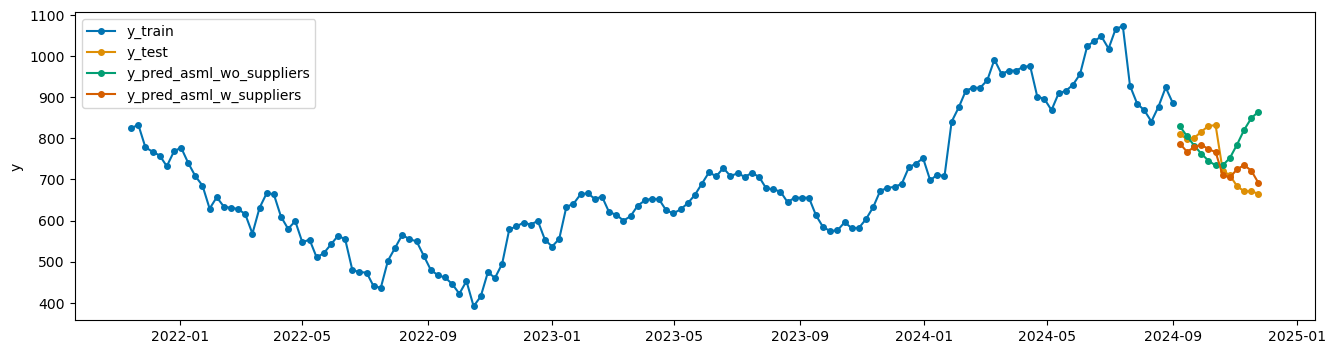

In [20]:
# Plot the series with train, test, and predictions from both models
plot_series(
    train_data['y'][200:],          # Training data starting from index 500 for better visualization
    test_data['y'],                 # Test data for comparison
    forecast_model_asml,            # Predictions from the ASML model
    forecast_model_asml_suppliers,  # Predictions from the ASML suppliers model
    labels=["y_train", "y_test", "y_pred_asml_wo_suppliers", "y_pred_asml_w_suppliers"]  # Labels for each line in the plot
)

#### 2.3.6.2 Comparing metrics

MAPE and RMSE of the model forecast_model_asml (without supplier/exogenous data)

In [21]:
print("MAPE:", best_prophet_variables_asml['mape_prophet_best'])
print()
print("RMSE:", best_prophet_variables_asml['rmse_prophet_best'])

MAPE: 11.290908261484876

RMSE: 102.67801168152953


MAPE and RMSE of the model forecast_model_asml_suppliers (with supplier/exogenous data)

In [22]:
print("MAPE:", best_prophet_variables_asml_suppliers['mape_prophet_best_with_suppliers'])
print()
print("RMSE:", best_prophet_variables_asml_suppliers['rmse_prophet_best_with_suppliers'])

MAPE: 4.771421459190517

RMSE: 40.390917678555084


#### 2.3.6.3 Conclusions

In comparing the best_prophet_variables_asml model (without supplier/exogenous data) with the best_prophet_variables_asml_suppliers model (including supplier/exogenous data), several key insights emerged:

1. Model Performance: The inclusion of supplier and exogenous variables in best_prophet_variables_asml_suppliers resulted in improved the MAPE and RMSE values compared to best_prophet_variables_asml. This demonstrates that incorporating relevant external variables can enhance the predictive capabilities of the model.

2. Predictive Value of Exogenous Variables: The addition of supplier-specific data provided valuable context, likely capturing market dynamics and trends that affect ASML's stock price. This indicates that external factors, including supplier performance and geopolitical events, have a meaningful impact on ASML's future performance.

3. Practical Implications: The enhanced model (best_prophet_variables_asml_suppliers) is more robust and can potentially inform better strategic decisions by providing more accurate predictions. This model may be especially useful in scenarios where external market conditions are volatile, allowing for more adaptive planning and risk management.